In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import joblib
import matplotlib as plt
import seaborn as sns


In [2]:
df = pd.read_csv('../data/data_clean.csv')

In [7]:
df.head()

,Happiness Rank,Healthy life expectancy,Social support,Country,Economy,Generosity,Year,Freedom to make life choices,Region,Perceptions of corruption,Score
0,1,0.94143,1.34951,Switzerland,1.39651,0.29678,2015,0.66557,Western Europe,0.41978,7.587
1,2,0.94784,1.40223,Iceland,1.30232,0.43630,2015,0.62877,Western Europe,0.14145,7.561
2,3,0.87464,1.36058,Denmark,1.32548,0.34139,2015,0.64938,Western Europe,0.48357,7.527
3,4,0.88521,1.33095,Norway,1.45900,0.34699,2015,0.66973,Western Europe,0.36503,7.522
4,5,0.90563,1.32261,Canada,1.32629,0.45811,2015,0.63297,North America,0.32957,7.427


In [3]:
df = pd.get_dummies(df, columns=['Region'], drop_first=True)

In [4]:
df.drop(columns=['Country', 'Happiness Rank'], axis=1, inplace=True)

In [5]:
X = df.drop(columns=['Score']) 
y = df['Score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)  
    ]
)

In [32]:
models = {
    'Linear_Regression': LinearRegression(),
    'Random_Forest': RandomForestRegressor(random_state=42),
    'Gradient_Boosting': GradientBoostingRegressor(random_state=42),
    'Support_Vector_Regression': SVR(),
    'KNN_Regression': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(random_state=42)
}

In [42]:
def evaluate_models(X_train, y_train, X_test, y_test, models):
    results = {}
    best_model_name = None
    best_r2 = -float('inf') 
    best_pipeline = None

    for model_name, model in models.items():
        pipeline = Pipeline(steps=[  
            ('preprocessor', preprocessor),
            ('regressor', model)  
        ])
        
        pipeline.fit(X_train, y_train)  
        
        y_pred = pipeline.predict(X_test) 
        
        mae = mean_absolute_error(y_test, y_pred)
        mse_value = mean_squared_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)  # Usando root_mean_squared_error
        r2 = r2_score(y_test, y_pred)

        results[model_name] = {
            'MAE': mae,
            'MSE': mse_value,
            'RMSE': rmse,
            'R²': r2
        }

        print("---------------------------------------------------------")
        print(f"{model_name} Results:")
        print(f"R²: {r2:.4f} \nMAE: {mae:.4f}, MSE: {mse_value:.4f}, RMSE: {rmse:.4f}")
        print("---------------------------------------------------------")
        
        if r2 > best_r2:
            best_r2 = r2
            best_model_name = model_name
            best_pipeline = pipeline

    if best_pipeline is not None:
        best_model_path = f'../model/best_model_{best_model_name}.pkl'
        joblib.dump(best_pipeline, f'../model/best_model_{best_model_name}.pkl')
        print(f"Best model saved as: ../model/best_model_{best_model_name}.pkl")
    
    return best_model_path


In [47]:
best_model_path = evaluate_models(X_train, y_train, X_test, y_test, models)

---------------------------------------------------------
Linear_Regression Results:
R²: 0.7632 
MAE: 0.4201, MSE: 0.2957, RMSE: 0.5438
---------------------------------------------------------
---------------------------------------------------------
Random_Forest Results:
R²: 0.8170 
MAE: 0.3723, MSE: 0.2285, RMSE: 0.4780
---------------------------------------------------------
---------------------------------------------------------
Gradient_Boosting Results:
R²: 0.8025 
MAE: 0.3916, MSE: 0.2466, RMSE: 0.4966
---------------------------------------------------------
---------------------------------------------------------
Support_Vector_Regression Results:
R²: 0.8144 
MAE: 0.3715, MSE: 0.2318, RMSE: 0.4814
---------------------------------------------------------
---------------------------------------------------------
KNN_Regression Results:
R²: 0.7914 
MAE: 0.3927, MSE: 0.2605, RMSE: 0.5104
---------------------------------------------------------
-----------------------------

In [64]:
best_pipeline = joblib.load(best_model_path)

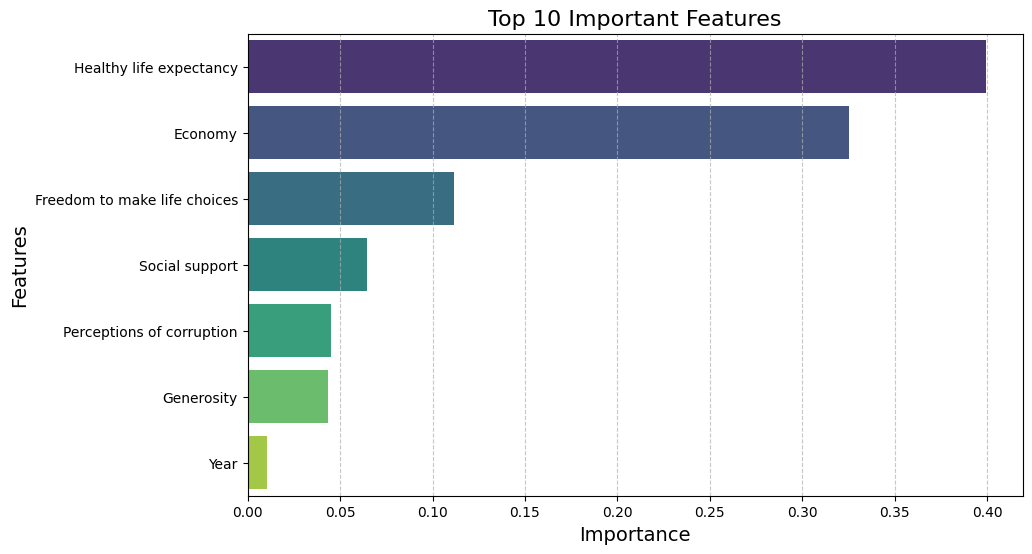

In [77]:
importances = best_pipeline.named_steps['regressor'].feature_importances_

feature_names = [col for col in num_cols if col != 'Score'] 

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis', dodge=False, hue='Feature', legend=False)
plt.title('Top 10 Important Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()